Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 9 - Modeling Volatility with GARCH class models

## 9.1 Modeling stock returns' volatility with ARCH models

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [4]:
RISKY_ASSET = "GOOG"
START_DATE = "2015-01-01"
END_DATE = "2021-12-31"

3. Download data from Yahoo Finance:

In [5]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

print(f"Downloaded {df.shape[0]} rows of data.")

[*********************100%***********************]  1 of 1 completed
Downloaded 1763 rows of data.


4. Calculate daily returns:

Average return: 0.11%


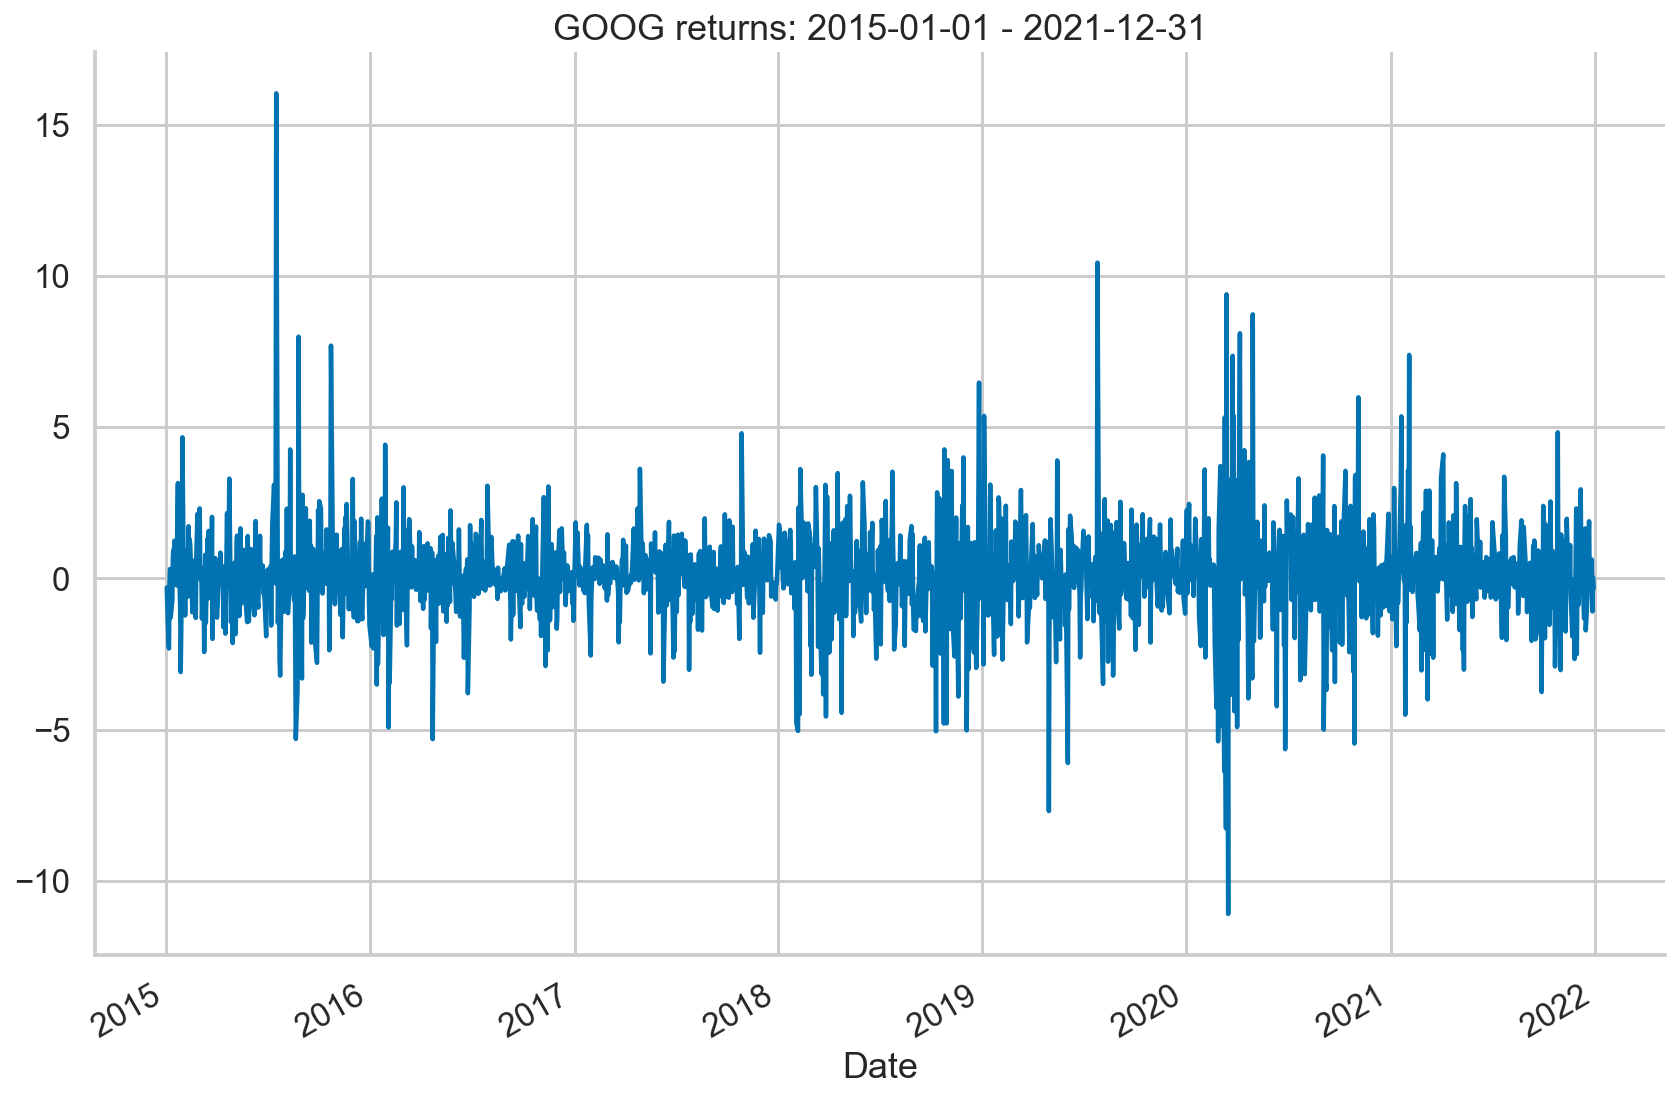

In [6]:
returns = 100 * df["Adj Close"].pct_change().dropna()
returns.name = "asset_returns"
print(f"Average return: {round(returns.mean(), 2)}%")
returns.plot(title=f"{RISKY_ASSET} returns: {START_DATE} - {END_DATE}");

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_1", dpi=200)

5. Specify the ARCH model:

In [7]:
model = arch_model(returns, mean="Zero", vol="ARCH", p=1, q=0)

6. Estimate the model and print the summary:

In [8]:
fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3302.93
Distribution:                  Normal   AIC:                           6609.85
Method:            Maximum Likelihood   BIC:                           6620.80
                                        No. Observations:                 1762
Date:                Wed, Jun 08 2022   Df Residuals:                     1762
Time:                        23:13:59   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.8625      0.166     11.248  2.359e-29 [  1.538,  2.18

7. Plot the residuals and the conditional volatility:

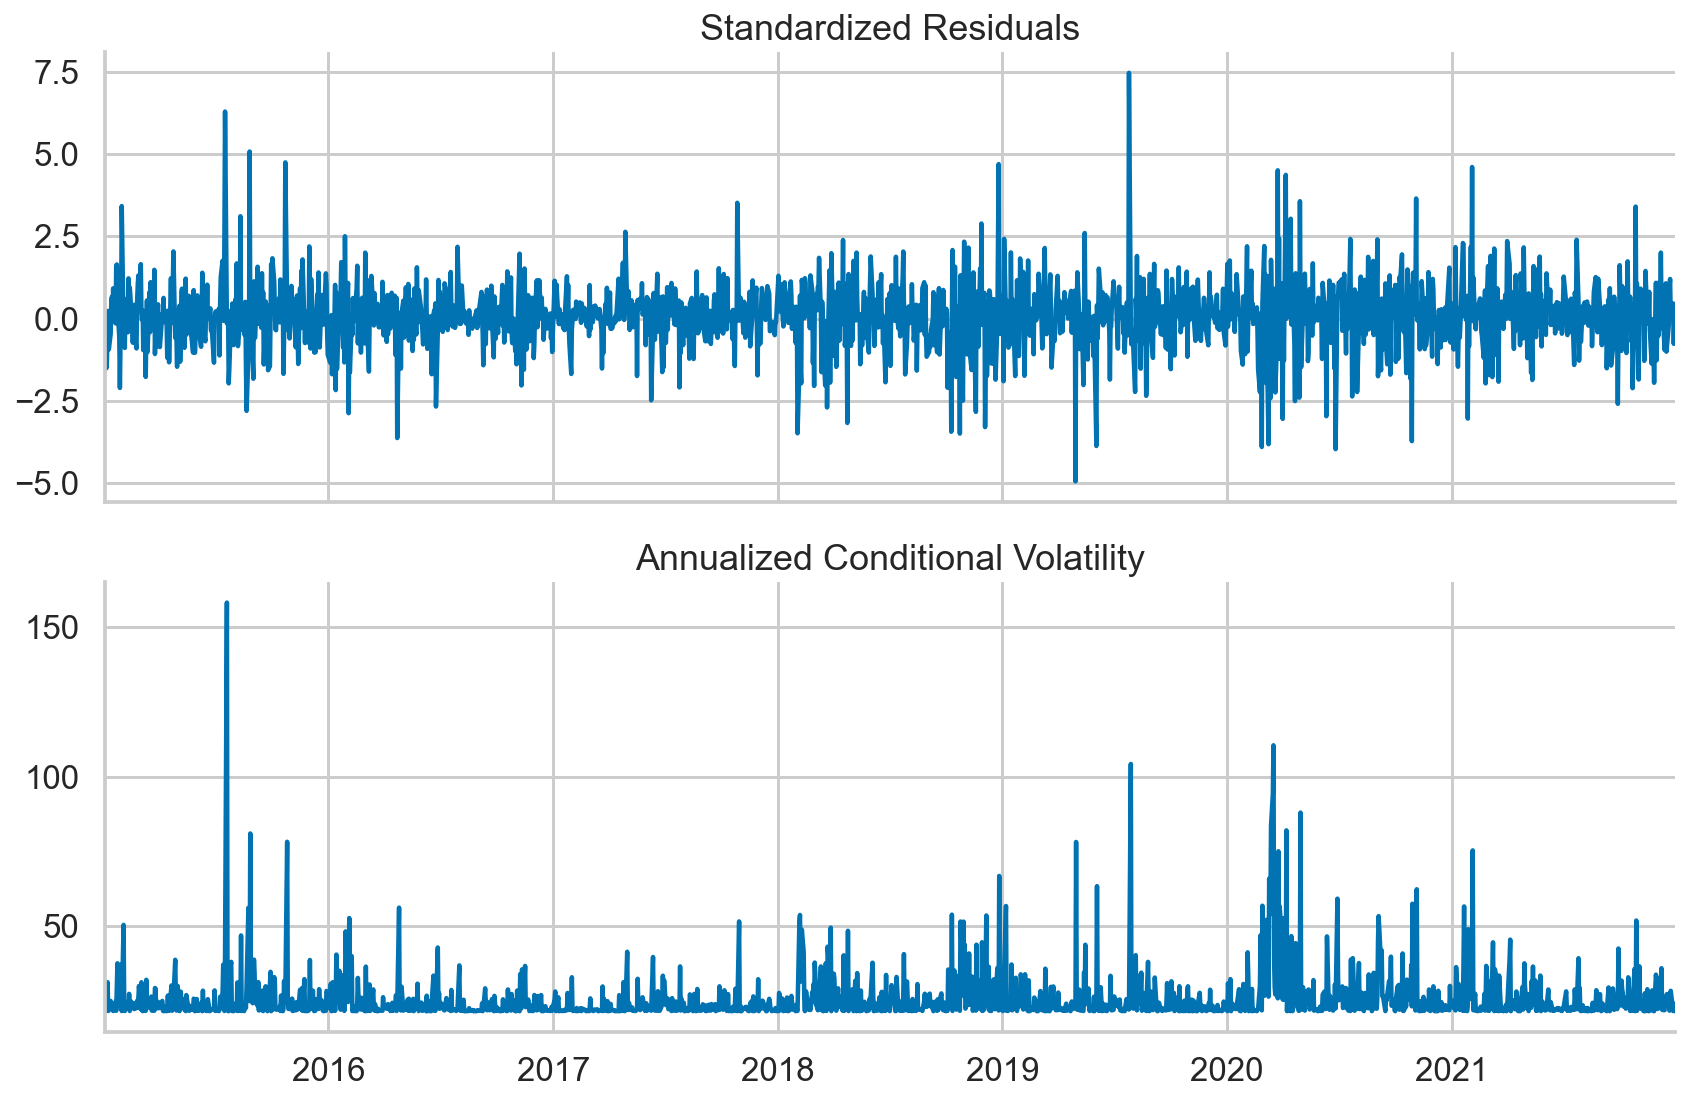

In [9]:
fitted_model.plot(annualize="D")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_2", dpi=200)

In the cell below we confirm that the standardized residuals are simply residuals divided by the conditional volatility.

In [10]:
diagnostics_dict = {
    "resids": fitted_model.resid,
    "conditional_volatility": fitted_model.conditional_volatility,
    "std_resid": fitted_model.std_resid,
    "std_resid_manual": fitted_model.resid / fitted_model.conditional_volatility,
}

df_diagnostics = pd.DataFrame(data = diagnostics_dict)
df_diagnostics

,resids,conditional_volatility,std_resid,std_resid_manual
Date,,,,
2015-01-02,-0.302049,1.644877,-0.183630,-0.183630
2015-01-05,-2.084573,1.377349,-1.513467,-1.513467
2015-01-06,-2.317705,1.873087,-1.237372,-1.237372
2015-01-07,-0.171326,1.974130,-0.086786,-0.086786
2015-01-08,0.315308,1.368814,0.230351,0.230351
...,...,...,...,...
2021-12-23,0.131682,1.793949,0.073404,0.073404
2021-12-27,0.626261,1.367151,0.458078,0.458078
2021-12-28,-1.091422,1.418129,-0.769621,-0.769621


### There's more

Test the residuals of the ARCH(1) model with the LM test.

In [11]:
from statsmodels.stats.diagnostic import het_arch
het_arch(fitted_model.resid)

(98.10927835448462,
 1.3015895084235373e-16,
 10.327662606705633,
 4.212426922910714e-17)

As the residuals come from a model in which we estimated two parameters (omega and alpha), we should correct for that when using the `het_arch` test.

In [12]:
het_arch(fitted_model.resid, ddof=2)

(97.9972814613859,
 1.370413812128847e-16,
 10.327662606705633,
 4.212426922910714e-17)

## 9.2 Modeling stock returns' volatility with GARCH models

### How to do it...

1. Specify the GARCH model:

In [13]:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

2. Estimate the model and print the summary:

In [14]:
fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3246.71
Distribution:                  Normal   AIC:                           6499.42
Method:            Maximum Likelihood   BIC:                           6515.84
                                        No. Observations:                 1762
Date:                Wed, Jun 08 2022   Df Residuals:                     1762
Time:                        23:14:03   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2864      0.186      1.539      0.124 [-7.84

3. Plot the residuals and the conditional volatility:

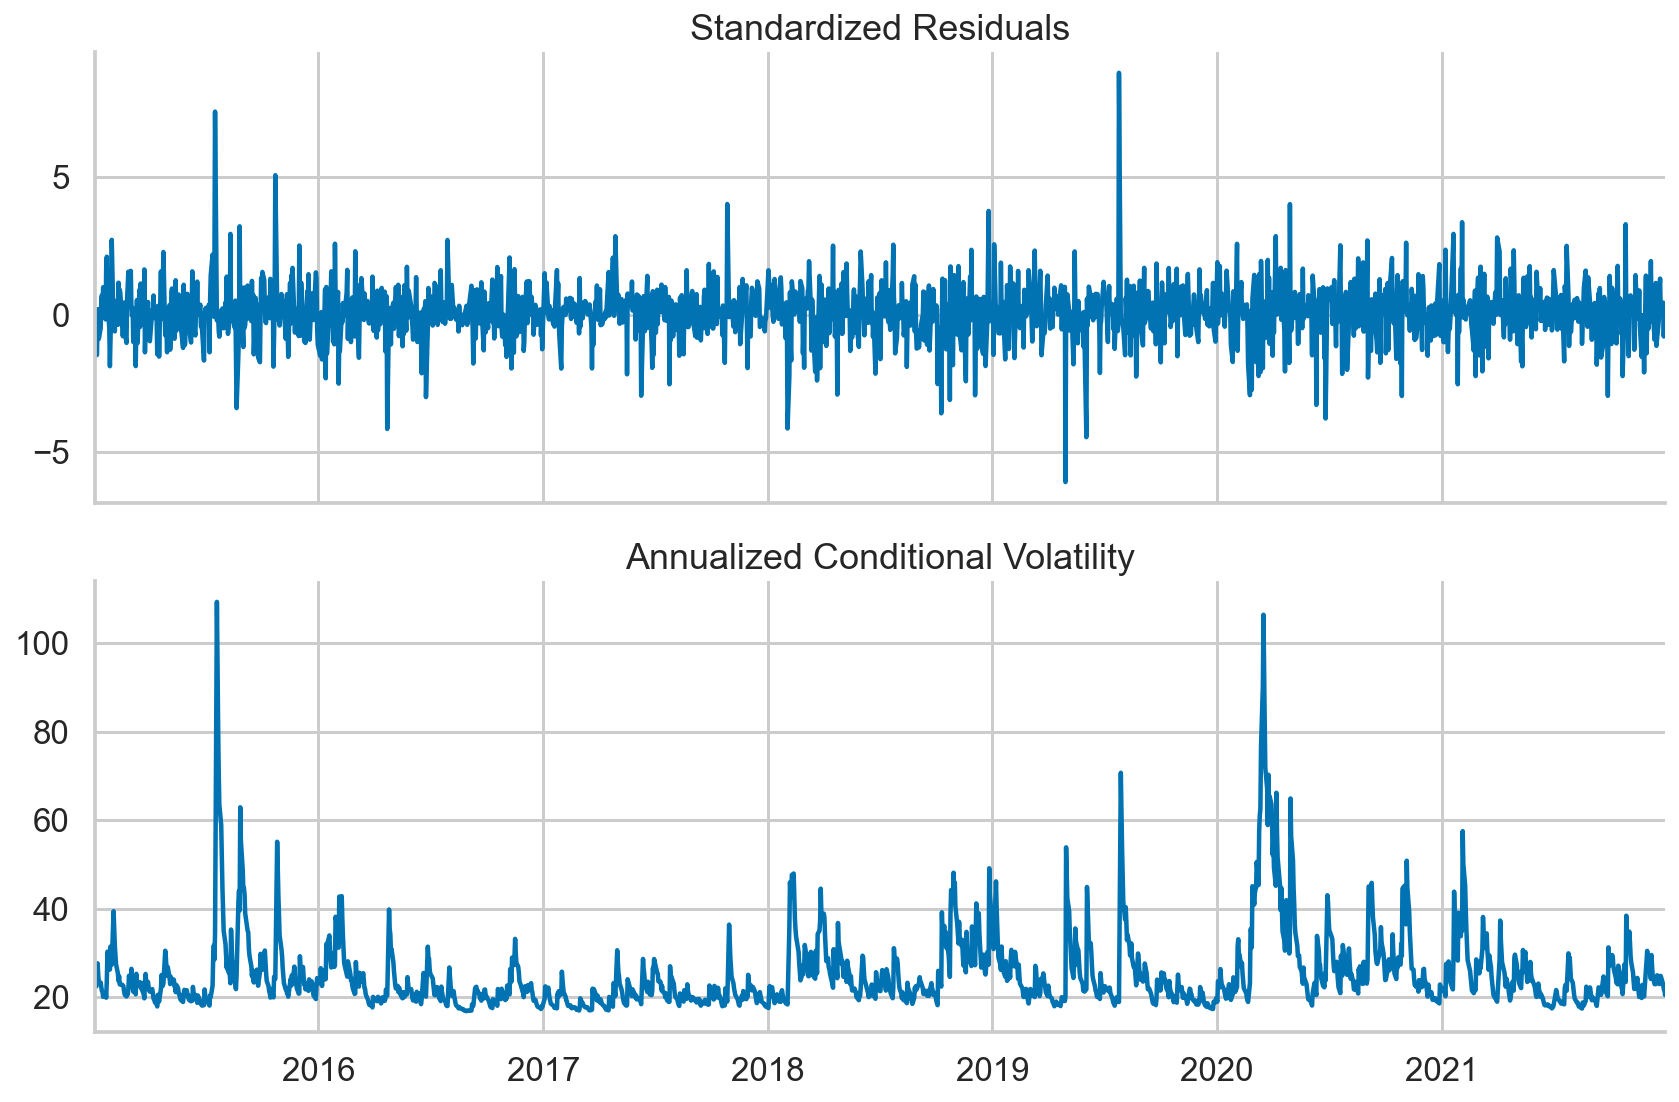

In [15]:
fitted_model.plot(annualize="D")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_3", dpi=200)

## 9.3 Forecasting volatility using GARCH models

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from arch import arch_model

2. Download data from Yahoo Finance and calculate simple returns:

In [4]:
df = yf.download("MSFT",
                 start="2015-01-01",
                 end="2021-12-31",
                 adjusted=True)

returns = 100 * df["Adj Close"].pct_change().dropna()
returns.name = "asset_returns"

[*********************100%***********************]  1 of 1 completed


3. Specify the GARCH model:

In [5]:
model = arch_model(returns, mean="Zero", vol="GARCH", dist="t",
                   p=1, q=1)

4. Define the split date and fit the model:

In [6]:
SPLIT_DATE = datetime(2021, 1, 1)
fitted_model = model.fit(last_obs=SPLIT_DATE, disp="off")

5. Create and inspect the analytical forecasts:

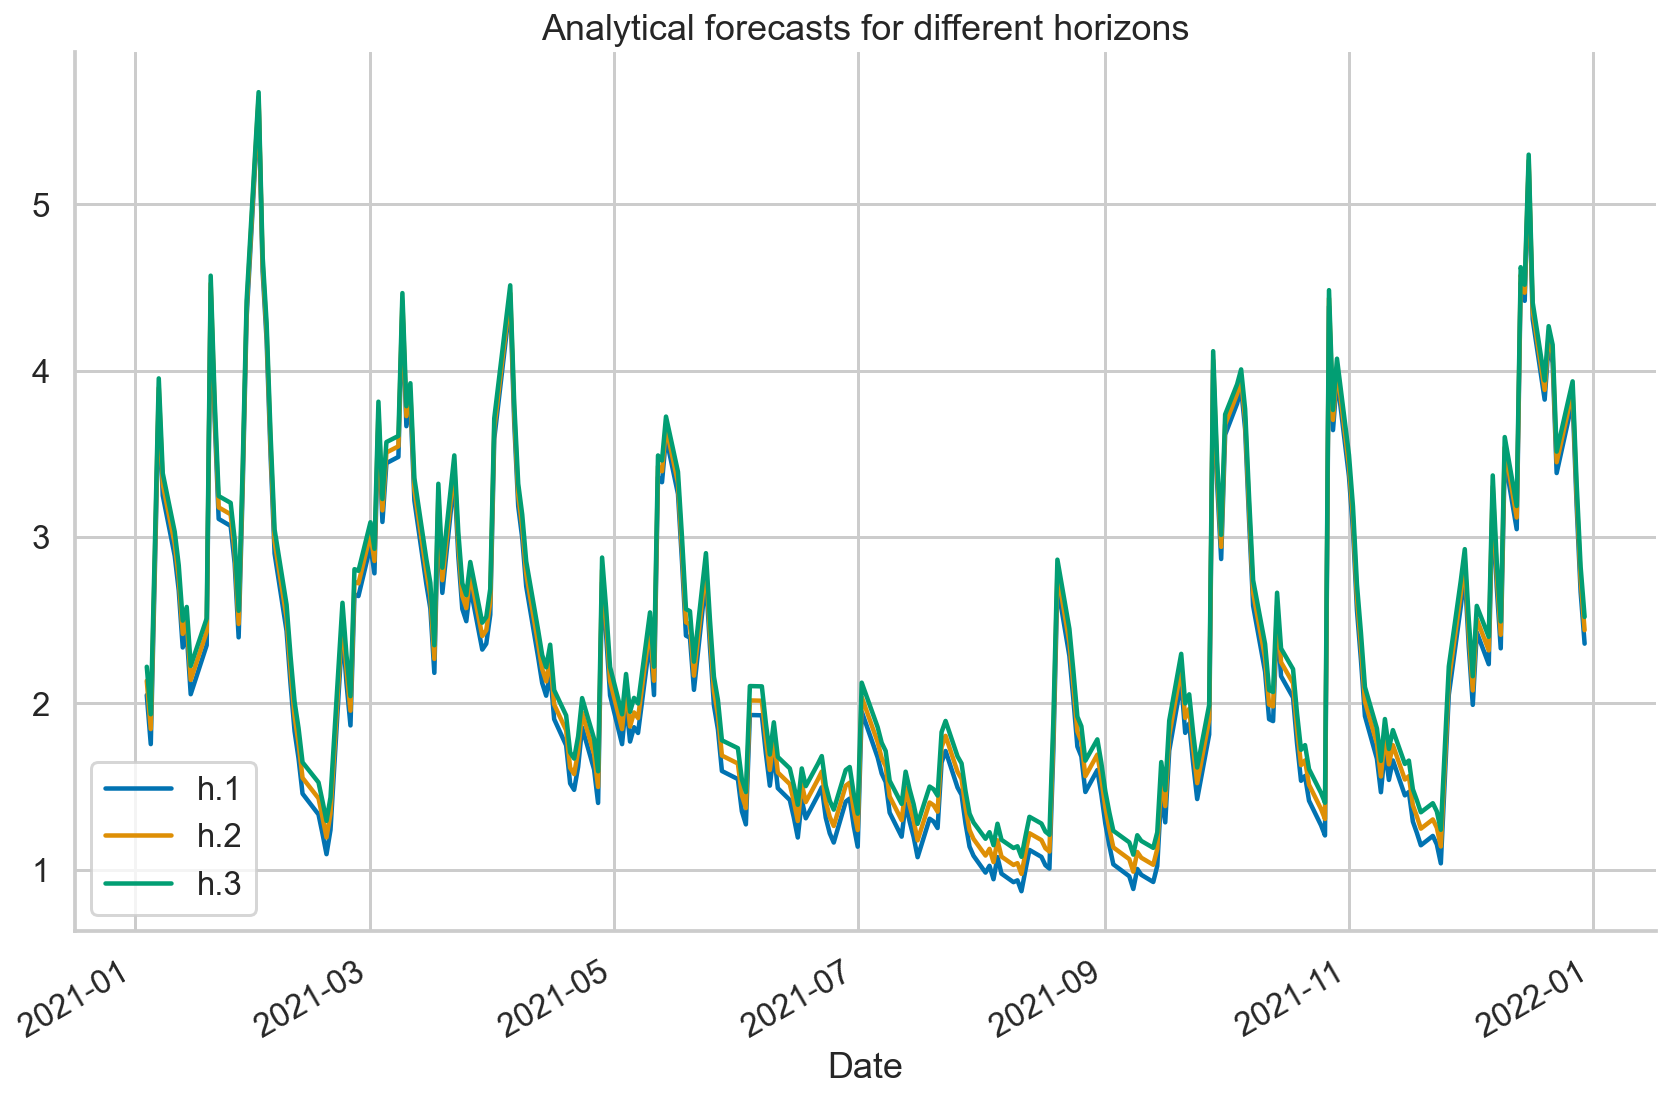

In [7]:
forecasts_analytical = fitted_model.forecast(horizon=3, 
                                             start=SPLIT_DATE,
                                             reindex=False)
forecasts_analytical.variance.plot(
    title="Analytical forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_4", dpi=200)

In [8]:
forecasts_analytical.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.050338,2.136146,2.220612
2021-01-05,1.755685,1.846101,1.935103
2021-01-06,2.772093,2.846613,2.919969
2021-01-07,3.839400,3.897229,3.954154
2021-01-08,3.250741,3.317776,3.383762
...,...,...,...
2021-12-23,3.385112,3.450046,3.513964
2021-12-27,3.821116,3.879231,3.936437
2021-12-28,3.189842,3.257829,3.324753


6. Create and inspect the simulation forecasts:

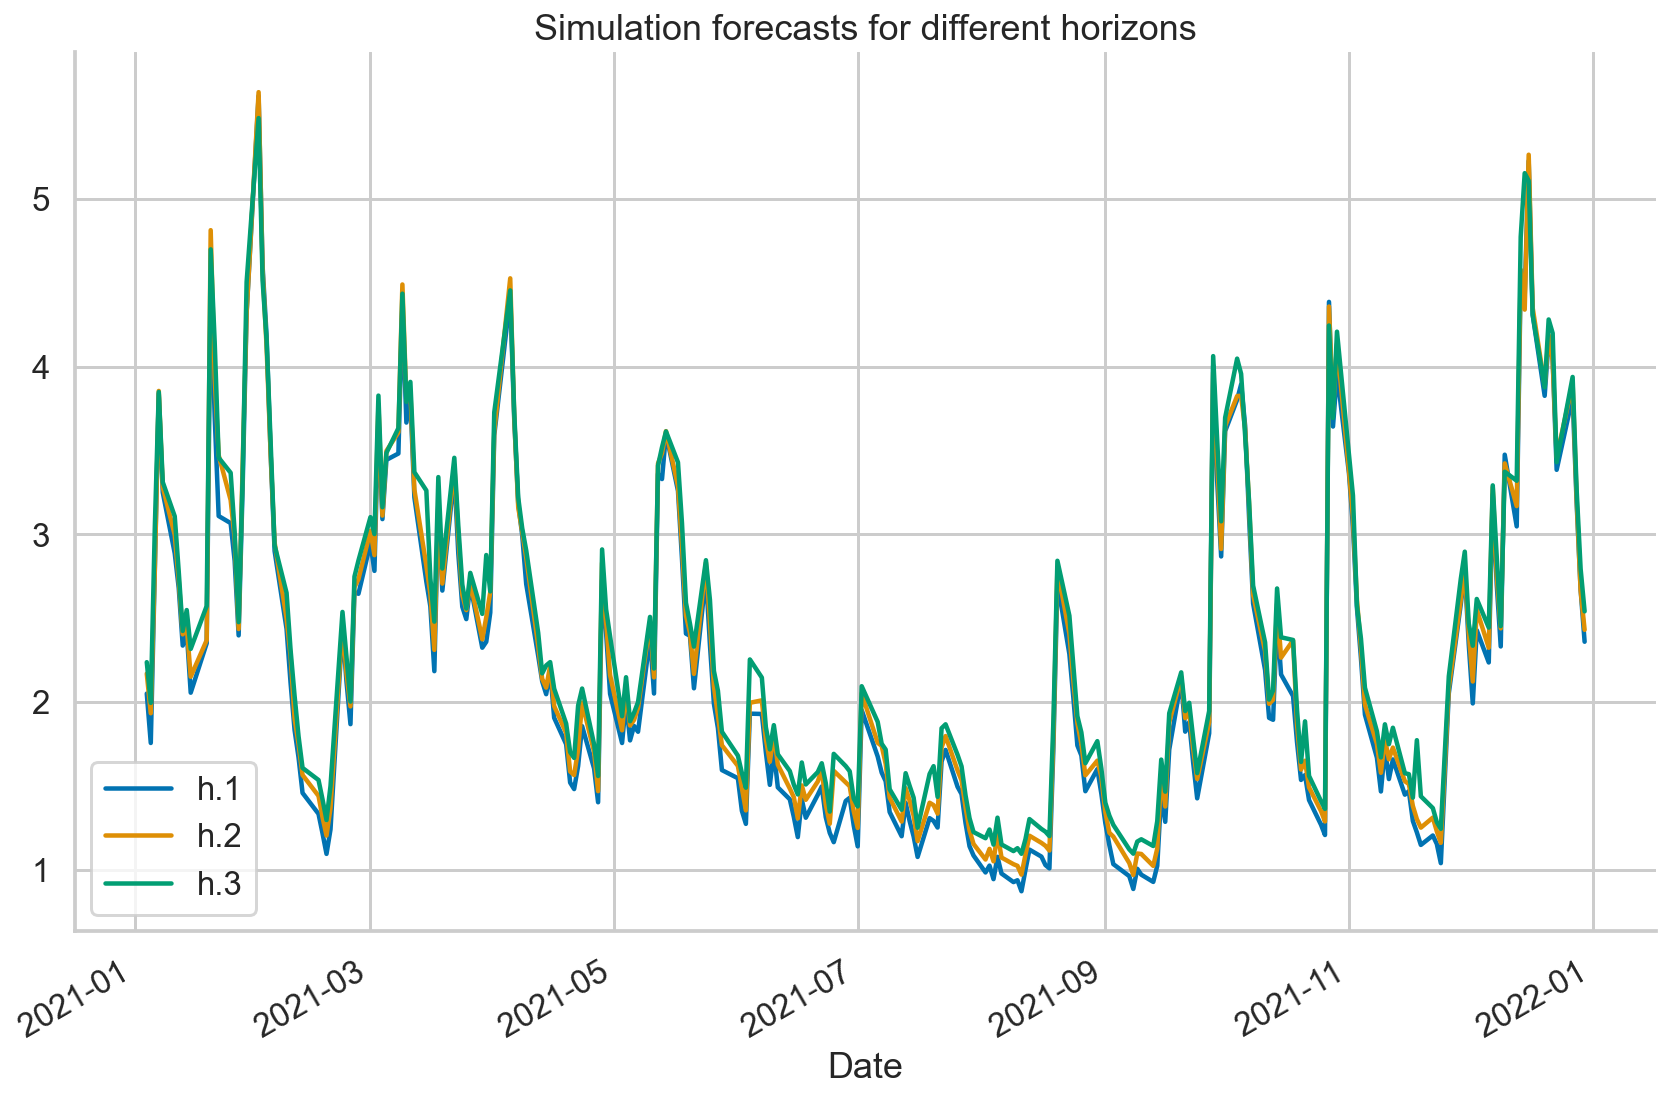

In [9]:
forecasts_simulation = fitted_model.forecast(horizon=3, 
                                             start=SPLIT_DATE,
                                             method="simulation",
                                             reindex=False)
forecasts_simulation.variance.plot(
    title="Simulation forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_6", dpi=200)

In [10]:
forecasts_simulation.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.050338,2.169295,2.237692
2021-01-05,1.755685,1.932794,1.994917
2021-01-06,2.772093,2.784876,3.031748
2021-01-07,3.839400,3.855641,3.849362
2021-01-08,3.250741,3.282011,3.311952
...,...,...,...
2021-12-23,3.385112,3.460921,3.430312
2021-12-27,3.821116,3.901822,3.938962
2021-12-28,3.189842,3.216940,3.267822


7. Create and inspect the bootstrap forecasts:

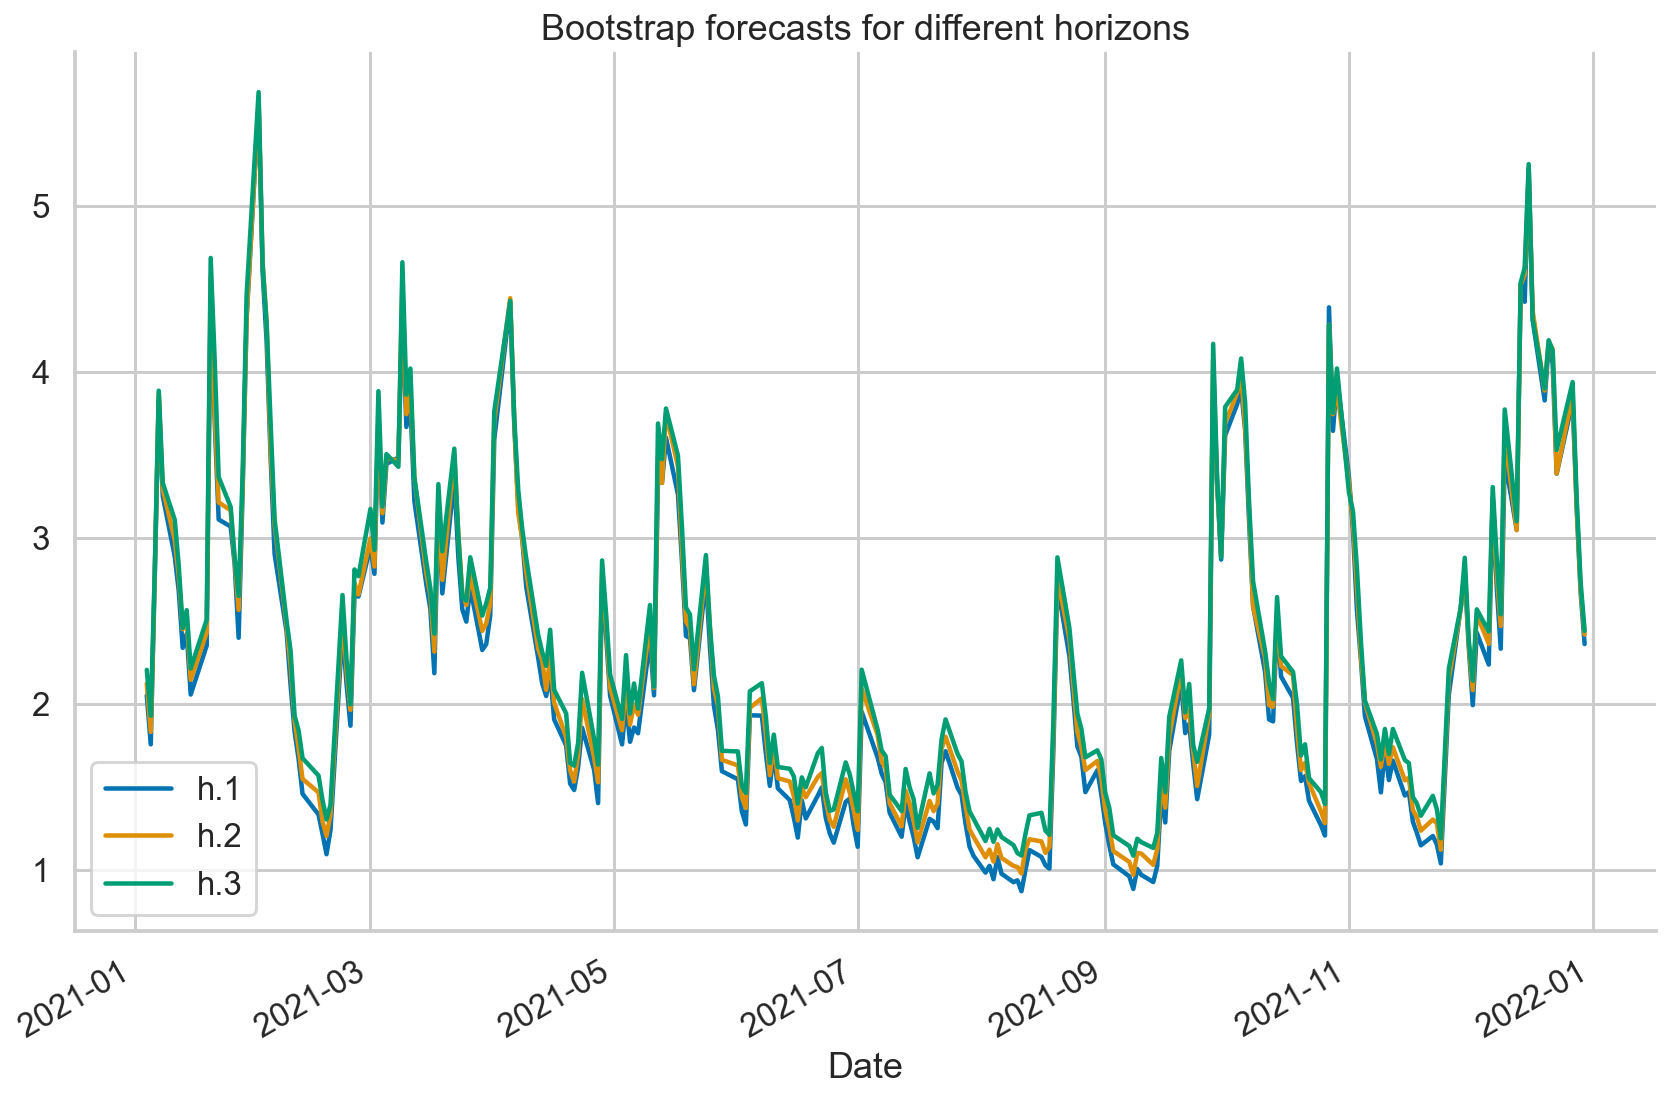

In [11]:
forecasts_bootstrap = fitted_model.forecast(horizon=3, 
                                            start=SPLIT_DATE,
                                            method="bootstrap",
                                            reindex=False)
forecasts_bootstrap.variance.plot(
    title="Bootstrap forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_7", dpi=200)

In [12]:
forecasts_bootstrap.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.050338,2.120546,2.204239
2021-01-05,1.755685,1.830604,1.927959
2021-01-06,2.772093,2.783396,2.799987
2021-01-07,3.839400,3.872276,3.885018
2021-01-08,3.250741,3.294436,3.329957
...,...,...,...
2021-12-23,3.385112,3.386089,3.527976
2021-12-27,3.821116,3.862573,3.936898
2021-12-28,3.189842,3.194487,3.246627


### There's more

1. Import the libraries:

In [13]:
import numpy as np

2. Estimate the volatility forecasts for 2020 using the analytic and bootstrap approaches:

In [23]:
# define the forecast horizon
FCST_HORIZON = 10

vol_analytic = (
    fitted_model.forecast(horizon=FCST_HORIZON, 
                          start=datetime(2020, 1, 1),
                          reindex=False)
    .residual_variance["2020"]
    .apply(np.sqrt)
)

vol_sim = (
    fitted_model.forecast(horizon=FCST_HORIZON, 
                          start=datetime(2020, 1, 1),
                          method="bootstrap",
                          reindex=False)
    .residual_variance["2020"]
    .apply(np.sqrt)
)


3. Get the conditional volatility for 2020:

In [24]:
vol = fitted_model.conditional_volatility["2020"]

4. Create the hedgehog plot:

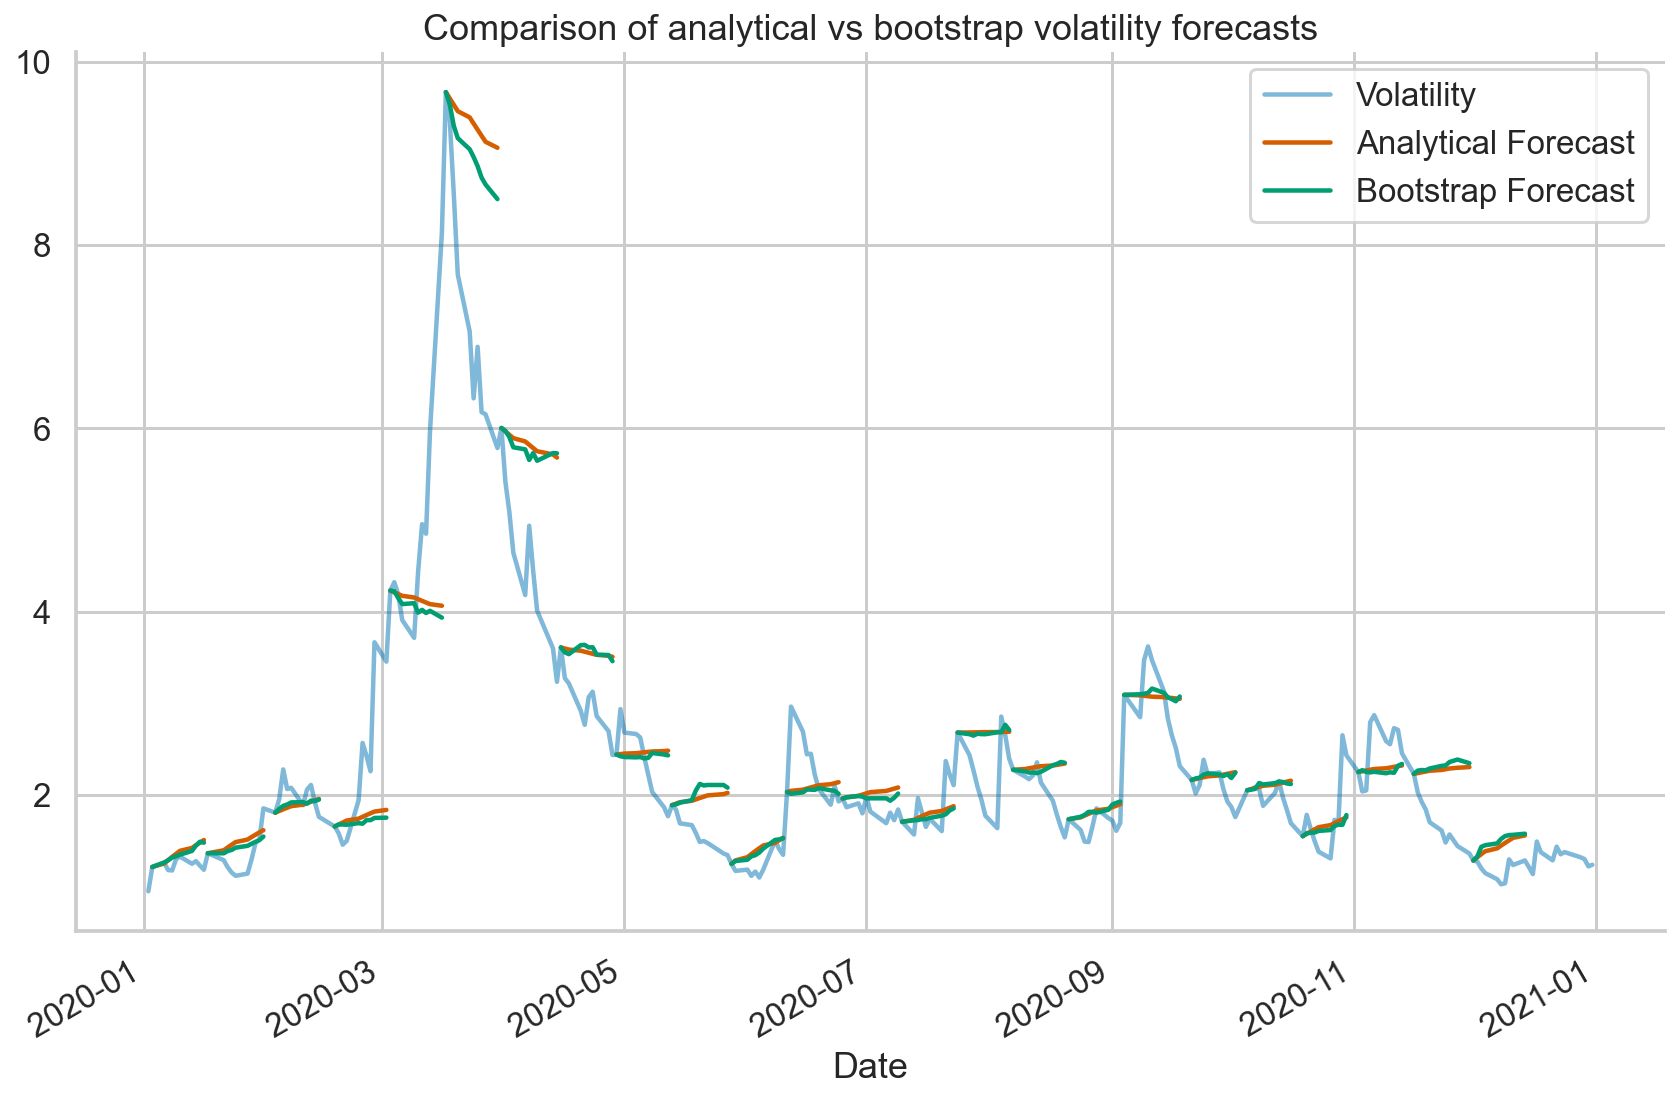

In [25]:
ax = vol.plot(
    title="Comparison of analytical vs bootstrap volatility forecasts",
    alpha=0.5
)
ind = vol.index

for i in range(0, 240, 10):
    vol_a = vol_analytic.iloc[i]
    vol_b = vol_sim.iloc[i]
    start_loc = ind.get_loc(vol_a.name)
    new_ind = ind[(start_loc+1):(start_loc+FCST_HORIZON+1)]
    vol_a.index = new_ind
    vol_b.index = new_ind
    ax.plot(vol_a, color="r")
    ax.plot(vol_b, color="g")

labels = ["Volatility", "Analytical Forecast", "Bootstrap Forecast"]
legend = ax.legend(labels)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_8", dpi=200)

## 9.4 Multivariate volatility forecasting with the CCC-GARCH model

### How to do it...

1. Import the libraries:

In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [27]:
RISKY_ASSETS = ["GOOG", "MSFT", "AAPL"]
START_DATE = "2015-01-01"
END_DATE = "2021-12-31"

3. Download data from Yahoo Finance:

In [28]:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

print(f"Downloaded {df.shape[0]} rows of data.")

[*********************100%***********************]  3 of 3 completed
Downloaded 1763 rows of data.


4. Calculate daily returns:

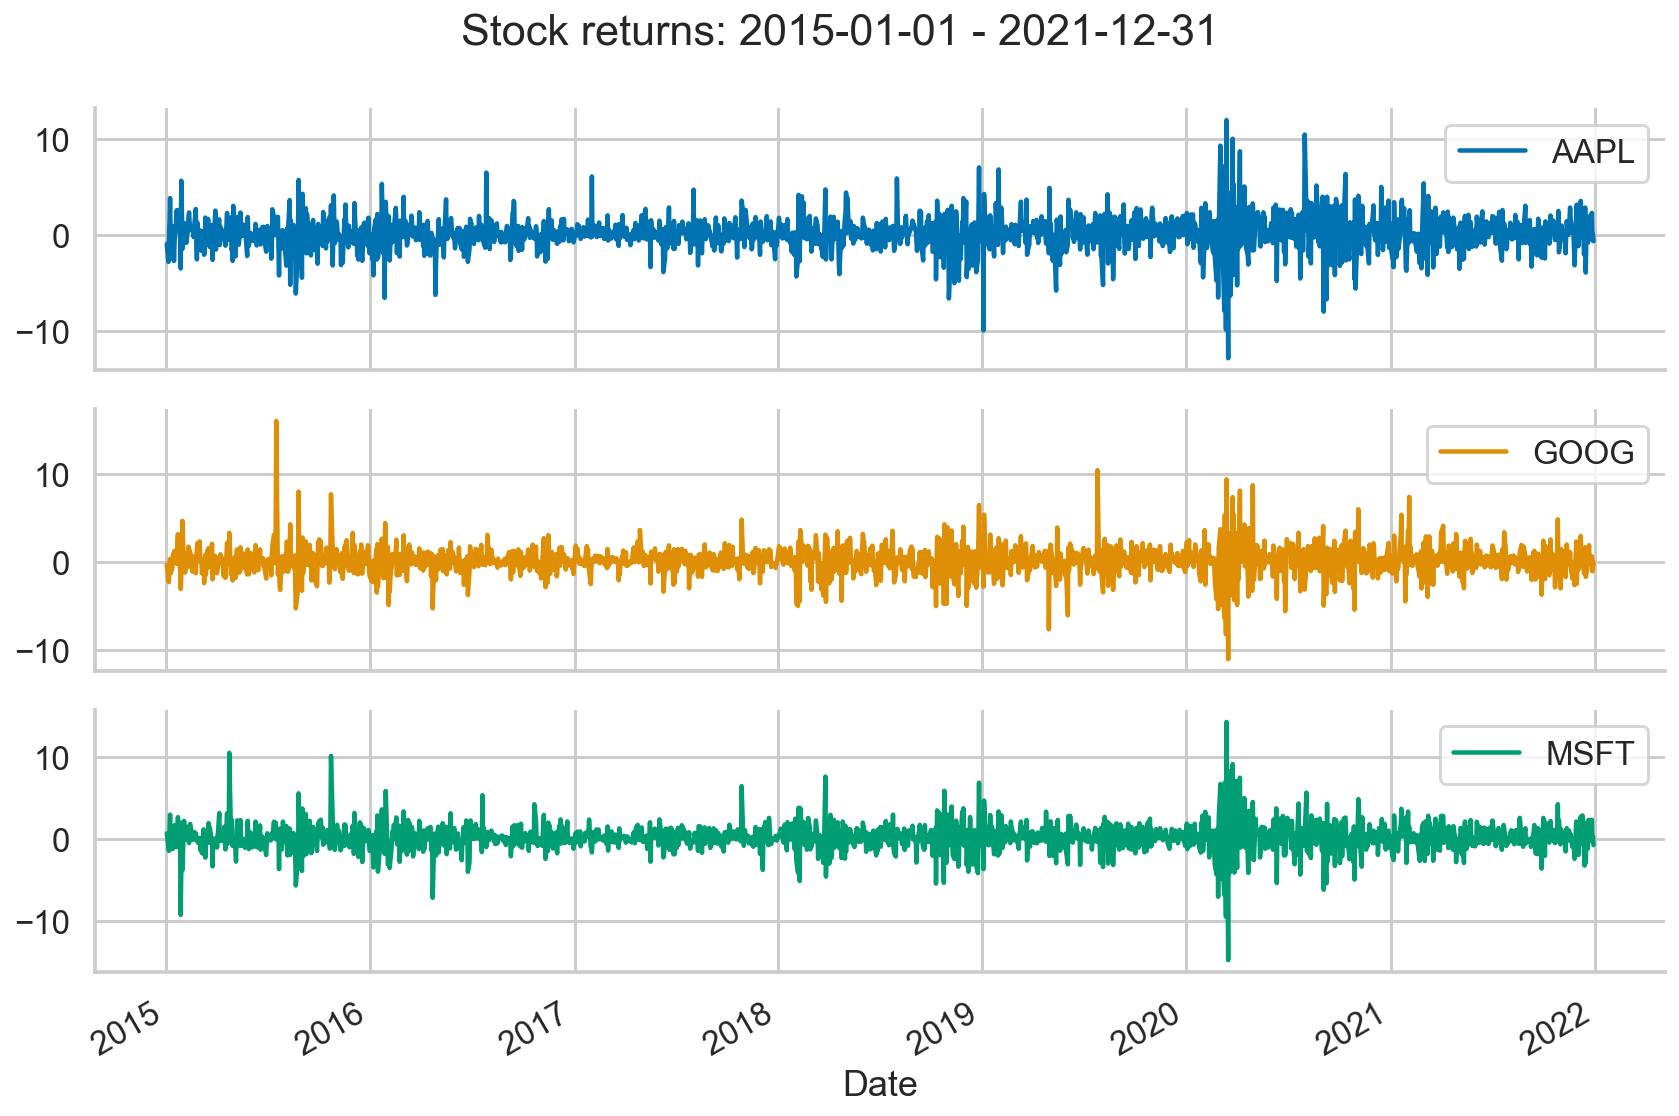

In [29]:
returns = 100 * df["Adj Close"].pct_change().dropna()
returns.plot(subplots=True, 
             title=f"Stock returns: {START_DATE} - {END_DATE}")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_9", dpi=200)

5. Define lists for storing objects:

In [30]:
coeffs = []
cond_vol = []
std_resids = []
models = []

6. Estimate the univariate GARCH models:

In [31]:
for asset in returns.columns:
    # specify and fit the model
    model = arch_model(returns[asset], mean="Constant", 
                       vol="GARCH", p=1, q=1).fit(update_freq=0, 
                                                  disp="off");
    # store results in the lists 
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.std_resid)
    models.append(model)

7. Store the results in DataFrames:

In [37]:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = (
    pd.DataFrame(cond_vol)
    .transpose()
    .set_axis(returns.columns,
              axis="columns", 
              inplace=False)
)
std_resids_df = (
    pd.DataFrame(std_resids)
    .transpose()
    .set_axis(returns.columns, 
              axis="columns", 
              inplace=False)
)

In [38]:
coeffs_df

,mu,omega,alpha[1],beta[1]
AAPL,0.189287,0.176098,0.134563,0.811815
GOOG,0.124954,0.304484,0.183056,0.716245
MSFT,0.149370,0.268674,0.213800,0.699576


8. Calculate the constant conditional correlation matrix (R):

In [41]:
R = (
    std_resids_df
    .transpose()
    .dot(std_resids_df)
    .div(len(std_resids_df))
)

9. Calculate the 1-step ahead forecast of the conditional covariance matrix :

In [55]:
# define objects
diag = []
D = np.zeros((len(RISKY_ASSETS), len(RISKY_ASSETS)))

# populate the list with conditional variances
for model in models:
    diag.append(model.forecast(horizon=1).variance.iloc[-1, 0])
# take the square root to obtain volatility from variance
diag = np.sqrt(diag)
# fill the diagonal of D with values from diag
np.fill_diagonal(D, diag)

# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)

In [56]:
H

array([[2.39962927, 1.00627983, 1.19839858],
       [1.00627983, 1.51608369, 1.12049108],
       [1.19839858, 1.12049108, 1.87400397]])

## 9.5 Forecasting the conditional covariance matrix using DCC-GARCH

### Getting ready

Before executing the following code, please make sure to run the code from the previous recipe to have the data available. 

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd

Setup the connection between Python and R using `rpy2`:

In [ ]:
%load_ext rpy2.ipython

2. Install `rmgarch` R package and load it:

In [ ]:
%%R

install.packages("rmgarch", repos = "http://cran.us.r-project.org")
library(rmgarch)

3. Import the dataset into R:

In [ ]:
%%R -i returns
print(head(returns, 5))

4. Define the model specification:

In [ ]:
%%R

# define GARCH(1,1) model
univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                              variance.model = list(garchOrder = c(1,1), 
                                                    model = "sGARCH"),
                              distribution.model = "norm")

# define DCC(1,1) model
n <- dim(returns)[2]
dcc_spec <- dccspec(uspec = multispec(replicate(n, univariate_spec)),
                    dccOrder = c(1,1),
                    distribution = "mvnorm")

dcc_spec

5. Estimate the model:

In [ ]:
%%R
dcc_fit <- dccfit(dcc_spec, data=returns)
dcc_fit

6. Calculate the 5-step ahead forecasts:

In [ ]:
%%R
forecasts <- dccforecast(dcc_fit, n.ahead = 5)

7. Access the forecasts:

In [ ]:
%%R

# conditional covariance matrix
forecasts@mforecast$H
# conditional correlation matrix
forecasts@mforecast$R
# proxy correlation process
forecasts@mforecast$Q
# conditional mean forecasts
forecasts@mforecast$mu

### There's more

In [ ]:
%%R

# parallelized DCC-GARCH(1,1)

library("parallel")

# set up the cluster
cl <- makePSOCKcluster(3)

# define parallelizable specification
parallel_fit <- multifit(multispec(replicate(n, univariate_spec)), 
                         returns, 
                         cluster = cl)

# fit the DCC-GARCH model
dcc_fit <- dccfit(dcc_spec, 
                  data = returns, 
                  fit.control = list(eval.se = TRUE), 
                  fit = parallel_fit, 
                  cluster = cl)

# stop the cluster
stopCluster(cl)

In [ ]:
%%R

dcc_fit